 ## 基于XGBoost的文本分类模型
  ### 但实际上效果不咋样：
  ##### 最佳参数: {'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 50} 
  ##### 最佳分数: 0.818978102189781
分类报告：
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.52      1.00      0.68       103
           2       0.67      0.04      0.07        51
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        10

    accuracy                           0.52       201
    
   macro avg       0.24      0.21      0.15       201
   
weighted avg       0.44      0.52      0.37       201


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blhq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\blhq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


最佳参数: {'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 50}
最佳分数: 0.818978102189781
分类报告：
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.52      1.00      0.68       103
           2       0.67      0.04      0.07        51
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        10

    accuracy                           0.52       201
   macro avg       0.24      0.21      0.15       201
weighted avg       0.44      0.52      0.37       201



D:\learn\paChong\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\learn\paChong\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\learn\paChong\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


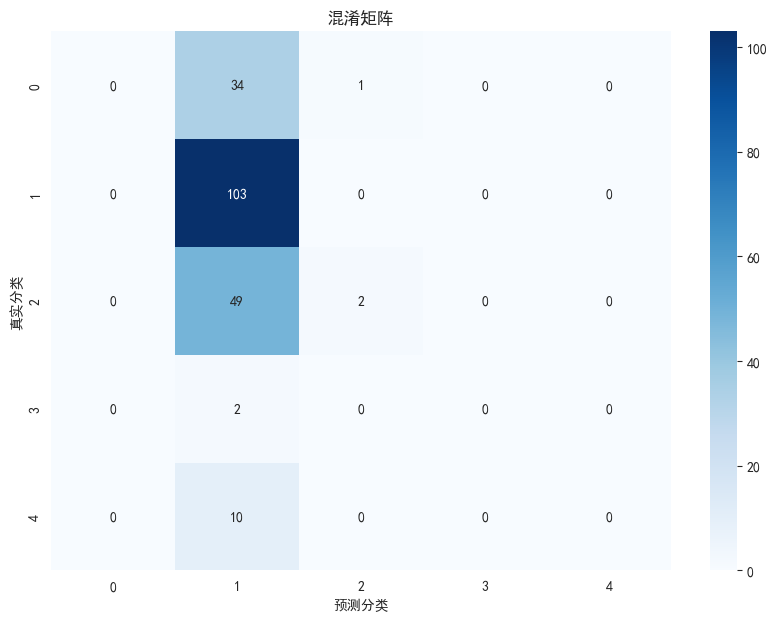

预测结果已保存到 '预测结果.xlsx' 文件中。


In [1]:
import matplotlib
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
# 设置字体为支持中文的字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
# 下载停用词和词形还原器（如果还没有下载过）
nltk.download('stopwords')
nltk.download('wordnet')
# 定义数据预处理函数
def preprocess_text(text):
    # 小写化
    text = text.lower()
    # 去除特殊字符和数字
    text = re.sub(r'[^a-zA-Z\u4e00-\u9fa5]', ' ', text)  # 保留汉字和英文字符
    # 分词
    words = text.split()
    # 去除停用词
    words = [word for word in words if word not in stopwords.words('chinese')]
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # 返回处理后的文本
    return ' '.join(words)

# 读取数据集
df = pd.read_excel('tieba.xlsx')  # 替换为你的文件名

# 假设 '标题' 列是你的文本，'分类（杂谈1、互助2、生活分享3、交流合作4、闲置5）' 列是你的标注数据
texts = df['标题'].tolist()
labels = df['分类（杂谈1、互助\t2、生活分享3、交流合作4、闲置5）'].tolist()

# 数据预处理
processed_texts = [preprocess_text(text) for text in texts]

# 选择手动标注的数据
labeled_texts = [text for text, label in zip(processed_texts, labels) if pd.notna(label)]
labeled_labels = [int(label) - 1 for label in labels if pd.notna(label)]  # 将标签转换为整数并减去 1

# 将手动标注的数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    labeled_texts, labeled_labels, test_size=0.2, random_state=42, stratify=labeled_labels)

# 将未标注的数据分开
unlabeled_texts = [text for text, label in zip(processed_texts, labels) if pd.isna(label)]

# 使用SMOTE进行过采样
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vect, y_train)

# 创建一个流水线并进行网格搜索以调整超参数
pipeline = Pipeline([
    ('clf', XGBClassifier(eval_metric='mlogloss', n_jobs=-1))  # 移除 use_label_encoder 参数
])

# 定义参数网格
param_grid = {
    'clf__max_depth': [5, 10, 15],
    'clf__n_estimators': [50, 100, 150],
    'clf__learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train_balanced, y_train_balanced)

# 获取最佳参数和分数
print("最佳参数:", grid_search.best_params_)
print("最佳分数:", grid_search.best_score_)

# 预测测试集的分类
y_pred = grid_search.predict(X_test_vect)

# 打印分类报告
print("分类报告：")
print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid_search.best_estimator_.classes_, yticklabels=grid_search.best_estimator_.classes_)
plt.title('混淆矩阵')
plt.xlabel('预测分类')
plt.ylabel('真实分类')
plt.show()

# 预测未标注数据的分类
X_unlabeled_vect = vectorizer.transform(unlabeled_texts)
predicted_labels = grid_search.predict(X_unlabeled_vect)

# 将预测结果存储到一个 DataFrame 中
predicted_df = pd.DataFrame({
    '标题': unlabeled_texts,
    '预测分类': predicted_labels + 1  # 预测结果转换回原始标签（1-5）
})

# 将结果保存到 Excel 文件
predicted_df.to_excel('预测结果.xlsx', index=False)

print("预测结果已保存到 '预测结果.xlsx' 文件中。")


## transformer 模型

In [9]:
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

# 下载停用词（如果还没有下载过）
nltk.download('stopwords')

# 定义数据预处理函数
def preprocess_text(text):
    # 小写化
    text = text.lower()
    # 去除特殊字符和数字，保留汉字和英文字符
    text = re.sub(r'[^a-zA-Z\u4e00-\u9fa5]', ' ', text)
    return text

# 读取数据集
df = pd.read_excel('tieba.xlsx')  # 替换为你的文件名

# 假设 '标题' 列是你的文本，'分类（杂谈1、互助2、生活分享3、交流合作4、闲置5）' 列是你的标注数据
texts = df['标题'].tolist()
labels = df['分类（杂谈1、互助\t2、生活分享3、交流合作4、闲置5）'].tolist()

# 数据预处理
processed_texts = [preprocess_text(text) for text in texts]

# 将标签转换为整数并减去 1
labeled_labels = [int(label) - 1 for label in labels if pd.notna(label)]
labeled_texts = [text for text, label in zip(processed_texts, labels) if pd.notna(label)]

# 确保文本和标签的长度一致
assert len(labeled_texts) == len(labeled_labels), "文本和标签长度不一致"

# 将手动标注的数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    labeled_texts, labeled_labels, test_size=0.2, random_state=42, stratify=labeled_labels)

# 加载BERT分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 对文本进行编码
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

# 创建数据集类
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 创建训练集和测试集
train_dataset = TextDataset(train_encodings, y_train)
test_dataset = TextDataset(test_encodings, y_test)

# 加载BERT模型
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=5)

# 设置训练参数
training_args = TrainingArguments(
    output_dir='./results2', #定义模型存放位置
    num_train_epochs=4, 
    #设置训练的 epoch 数，即重复学习次数，初始为3，当调整为10时，在第五次后出现了过拟合现象，所以采用：4次
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500, #定义学习率预热的步骤数
    weight_decay=0.01, #权重衰减系数（也称为 L2 正则化），用于防止过拟合
    logging_dir='./logs',
    logging_steps=10,
    # evaluation_strategy="epoch" # 未来版本可能不再支持
    eval_strategy="epoch",  
)

# 使用Trainer API进行训练
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 训练模型
trainer.train()

# 预测测试集的分类
predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = predictions.argmax(-1)

# 打印分类报告
print("分类报告：")
print(classification_report(y_test, predicted_labels))

# 将预测的标签和原始文本保存到 DataFrame 中
output_df = pd.DataFrame({
    '标题': X_test,
    '真实标签': y_test,
    '预测标签': predicted_labels
})

# 将结果保存到 Excel 文件
output_df.to_excel('prediction_results.xlsx', index=False)

print("预测结果已保存到 'prediction_results.xlsx'")

# 对未标注的数据进行预测并保存

# 提取未标注的数据
unlabeled_texts = df[df['分类（杂谈1、互助\t2、生活分享3、交流合作4、闲置5）'].isna()]['标题'].tolist()

# 打印未标注的数据数量和内容，确保数据被正确提取
print(f"未标注的数据数量: {len(unlabeled_texts)}")
# print(f"未标注的文本数据: {unlabeled_texts}")


# 如果有未标注的数据，进行处理
if len(unlabeled_texts) > 0:
    # 对未标注的文本进行编码
    unlabeled_encodings = tokenizer(unlabeled_texts, truncation=True, padding=True, max_length=128)

    # 创建未标注数据集
    class UnlabeledTextDataset(torch.utils.data.Dataset):
        def __init__(self, encodings):
            self.encodings = encodings

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            return item

        def __len__(self):
            return len(self.encodings['input_ids'])

    # 创建未标注数据集
    unlabeled_dataset = UnlabeledTextDataset(unlabeled_encodings)

    # 使用训练好的模型对未标注数据进行预测
    predictions, _, _ = trainer.predict(unlabeled_dataset)
    predicted_labels = predictions.argmax(-1)

    # 将预测的标签和未标注文本保存到 DataFrame 中
    unlabeled_df = pd.DataFrame({
        '标题': unlabeled_texts,
        '预测标签': predicted_labels
    })

    # 将未标注数据的预测结果填充到原始 DataFrame 中对应的位置
    df.loc[df['分类（杂谈1、互助\t2、生活分享3、交流合作4、闲置5）'].isna(), '分类（杂谈1、互助\t2、生活分享3、交流合作4、闲置5）'] = predicted_labels + 1

    # 将包含预测结果的原始数据保存到 Excel 文件
    df.to_excel('prediction_results_with_unlabeled.xlsx', index=False)

    print("未标注数据的预测结果已保存到 '重复5次的预测数据.xlsx'")
else:
    print("没有未标注的数据。")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blhq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.349500,1.223930
2,0.999200,0.930081
3,0.769800,0.755958
4,0.621800,0.691831


分类报告：
              precision    recall  f1-score   support

           0       0.74      0.54      0.63        48
           1       0.81      0.86      0.83       107
           2       0.66      0.80      0.73        51
           3       0.00      0.00      0.00         3
           4       1.00      0.83      0.91        12

    accuracy                           0.76       221
   macro avg       0.64      0.61      0.62       221
weighted avg       0.76      0.76      0.76       221

预测结果已保存到 'prediction_results.xlsx'
未标注的数据数量: 5755


D:\learn\paChong\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\learn\paChong\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\learn\paChong\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


未标注数据的预测结果已保存到 '重复5次的预测数据.xlsx'


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# 读取数据集
df = pd.read_excel('tieba.xlsx')  # 替换为你的文件名
texts = df['标题'].tolist()
labels = df['分类（杂谈1、互助\t2、生活分享3、交流合作4、闲置5）'].tolist()

# 选择手动标注的数据
labeled_texts = [text for text, label in zip(texts, labels) if pd.notna(label)]
labeled_labels = [label for label in labels if pd.notna(label)]

# 将手动标注的数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    labeled_texts, labeled_labels, test_size=0.2, random_state=42, stratify=labeled_labels)

# 使用TF-IDF将文本转为向量
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# 使用 SMOTE 进行过采样
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vect, y_train)

# 训练逻辑回归模型，使用类权重
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_balanced, y_train_balanced)

# 预测测试集的分类
y_pred = model.predict(X_test_vect)

# 打印分类报告
from sklearn.metrics import classification_report
print("分类报告：")
print(classification_report(y_test, y_pred))


In [ ]:
import pandas as pd

# 1、导入数据
df = pd.read_excel('tieba.xlsx')

# 查看数据结构
print(df.head())


In [ ]:
import re

# 2、清洗函数
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # 去掉HTML标签
    text = re.sub(r'[^\w\s]', '', text)  # 去掉标点符号
    return text.lower()

# 对文本数据进行清洗
df['清洗文本'] = df['标题'].apply(clean_text)  # 假设列名为 '文本内容'


In [ ]:
# 3. 特征提取
from sklearn.feature_extraction.text import TfidfVectorizer

# 使用TF-IDF将文本转为向量
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(df['清洗文本'])
# 目标标签
y = df['分类（杂谈1、互助\t2、生活分享3、交流合作4、闲置5）']  



## 以下是正常的东西

In [ ]:
# 划分训练集和测试集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 选择随机森林模型
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 进行预测
y_pred = model.predict(X_test)

# 评估模型
print(classification_report(y_test, y_pred))
print(f'准确率: {accuracy_score(y_test, y_pred)}')


In [ ]:
import joblib

# 保存模型
joblib.dump(model, '主题识别模型.pkl')
